In [1]:
# Imports
import os
import cv2
import pathlib
import numpy as np
from PIL import Image

from typing import Tuple, Optional, List

!pip3 install pillow-heif
from pillow_heif import register_heif_opener

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import distance_metrics

from keras.preprocessing.image import ImageDataGenerator

Data Augmentation.

In [6]:
def get_datasets(input_dir):
    """Get the preprocessed dataset and split it"""
    # Iterate through all of images in the input directory
    images = []
    labels = []
    for img in pathlib.Path(input_dir).iterdir():
        # Read the image and label
        image = cv2.imread(str(img))
        image = cv2.resize(image, (224, 224))
        # image = image.flatten()
        images.append(image)
        name = img.stem.split('_')[0]
        labels.append(name)

    images_arr = np.array(images)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        images_arr,
        labels,
        test_size=0.2,
        random_state=22
    )

    # Use PCA for dimension reduction
    # pca = PCA(n_components=16)
    # X_train = pca.fit_transform(X_train)
    # X_test = pca.transform(X_test)

    return X_train, X_test, y_train, y_test


# if __name__ == "__main__":
#     X_train, X_test, y_train, y_test = get_datasets(
#         input_dir="./Normalized_dnn"
#     )

In [7]:
X_train, X_test, y_train, y_test = get_datasets(
    input_dir="./train_preprocessed"
)

In [8]:
print(X_train.shape)

(936, 224, 224, 3)


In [9]:
# convert list to numpy array
y_train = np.array(y_train)
y_test = np.array(y_test)

In [10]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=33)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=33)

In [25]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# Define the model
model = models.Sequential()

# CNN model
# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for the fully connected layers
model.add(layers.Flatten())

# Dense (fully connected) layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))  # Dropout for regularization
model.add(layers.Dense(33, activation='softmax'))  # 33 output classes, one for each person

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 26, 26, 128)      

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

base_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(33, activation='softmax')  # Adjust num_classes based on your dataset
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 33)                8481      
                                                                 
Total params: 24120737 (92.01 MB)
Trainable params: 533025 (2.03 MB)
Non-trainable params: 23587712 (89.98 MB)
_________

In [45]:
# Train the model

history = model.fit(X_train, y_train, epochs=20, validation_batch_size=32, batch_size=64, verbose=1)

Epoch 1/20
15/15 [==============================] - 28s 2s/step - loss: 3.2868 - accuracy: 0.1335
Epoch 2/20
15/15 [==============================] - 27s 2s/step - loss: 2.1927 - accuracy: 0.4156
Epoch 3/20
15/15 [==============================] - 28s 2s/step - loss: 1.4426 - accuracy: 0.6464
Epoch 4/20
15/15 [==============================] - 28s 2s/step - loss: 0.9679 - accuracy: 0.7810
Epoch 5/20
15/15 [==============================] - 27s 2s/step - loss: 0.7012 - accuracy: 0.8440
Epoch 6/20
15/15 [==============================] - 27s 2s/step - loss: 0.5205 - accuracy: 0.8825
Epoch 7/20
15/15 [==============================] - 27s 2s/step - loss: 0.4130 - accuracy: 0.9209
Epoch 8/20
15/15 [==============================] - 27s 2s/step - loss: 0.2976 - accuracy: 0.9455
Epoch 9/20
15/15 [==============================] - 27s 2s/step - loss: 0.2487 - accuracy: 0.9594
Epoch 10/20
15/15 [==============================] - 28s 2s/step - loss: 0.2090 - accuracy: 0.9690
Epoch 11/20
15/15 [

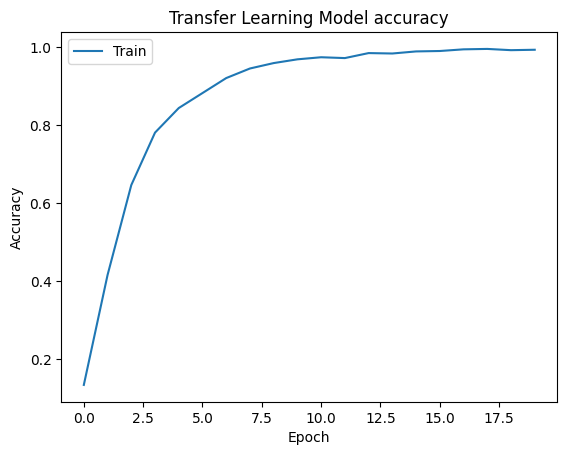

In [47]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.title('Transfer Learning Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [48]:
model.save('face_recognition_model.h5')

In [32]:
model.load_weights('test5.h5')

In [34]:
# test
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)

8/8 [==============================] - 1s 167ms/step - loss: 0.3568 - accuracy: 0.9447
